# Motivation
In today's financial landscape, taking out loans has become a standard practice for investors and individuals alike, whether for investment purposes or other needs. Nevertheless, banks are witnessing an uptick in loan defaults, prompting a need to enhance their credit risk evaluation methods to more accurately predict potential defaults.

In [12]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

Link to Loan Dataset from KAGGLE: [Loan Dataset](https://www.kaggle.com/datasets/somyaagarwal69/loan-data-2015/data)<br>
Please download the CSV from the above link before running the code below.

# 1. Data Preparation 

- Addressing NA Values: Filling NA values with the median of the original dat
- Regrouping Variable: For column 'loan_status', we decided to drop rows with Current/In Grace Period/Issue
- Dropping Data: Dropped columns that are deemed irrelevant and useless to the modeldat has


In [13]:
loandata = pd.read_csv("loan_data_2015.csv", low_memory=False)
loandata.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,60516983,64537751,20000,20000,20000,36 months,12.29,667.06,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,41000,NaN,NaN,NaN
1,60187139,64163931,11000,11000,11000,36 months,12.69,369.00,C,C2,...,NaN,NaN,NaN,NaN,NaN,NaN,13100,NaN,NaN,NaN
2,60356453,64333218,7000,7000,7000,36 months,9.99,225.84,B,B3,...,NaN,NaN,NaN,NaN,NaN,NaN,16300,NaN,NaN,NaN
3,59955769,63900496,10000,10000,10000,36 months,10.99,327.34,B,B4,...,NaN,NaN,NaN,NaN,NaN,NaN,34750,NaN,NaN,NaN
4,58703693,62544456,9550,9550,9550,36 months,19.99,354.87,E,E4,...,NaN,NaN,NaN,NaN,NaN,NaN,14100,NaN,NaN,NaN


In [14]:
loandata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421094 entries, 0 to 421093
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           421094 non-null  int64  
 1   member_id                    421094 non-null  int64  
 2   loan_amnt                    421094 non-null  int64  
 3   funded_amnt                  421094 non-null  int64  
 4   funded_amnt_inv              421094 non-null  int64  
 5   term                         421094 non-null  object 
 6   int_rate                     421094 non-null  float64
 7   installment                  421094 non-null  float64
 8   grade                        421094 non-null  object 
 9   sub_grade                    421094 non-null  object 
 10  emp_title                    397220 non-null  object 
 11  emp_length                   397277 non-null  object 
 12  home_ownership               421094 non-null  object 
 13 

From the above, we observed that our dataset consist of many different datatypes (object, float64 and int64) where some columms were observed to have null values too. Hence, we decided to clean the model by removing the columms that has more than 40% of the column that are empty.

In [15]:
#printing out a score based on number of null value in each columm that has more than 40% of null values
na_values = loandata.isnull().mean()
na_values[na_values>0.4]


desc                           0.999893
mths_since_last_delinq         0.484360
mths_since_last_record         0.823282
mths_since_last_major_derog    0.708547
annual_inc_joint               0.998786
dti_joint                      0.998791
verification_status_joint      0.998786
open_acc_6m                    0.949246
open_il_6m                     0.949246
open_il_12m                    0.949246
open_il_24m                    0.949246
mths_since_rcnt_il             0.950581
total_bal_il                   0.949246
il_util                        0.955789
open_rv_12m                    0.949246
open_rv_24m                    0.949246
max_bal_bc                     0.949246
all_util                       0.949246
inq_fi                         0.949246
total_cu_tl                    0.949246
inq_last_12m                   0.949246
dtype: float64

In [16]:
# We chose to drop these variable column as there are too many null values which does not assist us in our analysis
# drop columns with more than 40% null values
loandata.dropna(thresh = loandata.shape[0]*0.9, axis = 1, inplace = True)
loandata.shape

(421094, 53)

In [17]:
loandata['loan_status'].value_counts()

loan_status
Current               377553
Fully Paid             22984
Issued                  8460
Late (31-120 days)      4691
In Grace Period         3107
Charged Off             2773
Late (16-30 days)       1139
Default                  387
Name: count, dtype: int64

# Explaination of each row 

1. **Current**: Current loan cycle, but with a potential risk of default in the future.
2. **Fully Paid**: Borrowers who have already paid off the loan are considered non-risky.
3. **Issued**: Loans issued recently with no payment cycle yet, but with a potential risk of default in the future.
4. **Late (16-30 days)**: Borrowers who have delayed payment by 16-30 days, with uncertainty about future default.
5. **In Grace Period**: Borrowers who have delayed payment by 1-15 days, with uncertainty about future default.
6. **Charged Off**: Borrowers deemed incapable of paying the loan, marked as NPA (Non Performing Asset).
7. **Late (31-120 days)**: Borrowers who have delayed payment by more than 31 days.
8. **Default**: Borrowers who have not paid their loan even after 120 days.

## Rows we chose to drop
I will be excluding the following as they do not provide valuable insights to our model as they can go both ways(risk and non-risky) <br>
- Current  
- In Grace period  
- Issued

## Row Categorisation
We decided to group the remaining rows of loan status and catgorise them into either **risky** or **non-risky**
### Non-Risky
- Fully Paid
### Risky
- Charged Off
- Default
- Late (16-30 days)
- Late (31-120 days)

In [18]:
# Dropping columns that will not help us in predicting the credit risk

indexnew = loandata[ (loandata['loan_status'] == 'Current') ].index
loandata.drop(indexnew , inplace=True)
indexnew = loandata[ (loandata['loan_status'] == 'Issued')  ].index
loandata.drop(indexnew , inplace=True)
indexnew = loandata[ (loandata['loan_status'] == 'In Grace Period') ].index
loandata.drop(indexnew , inplace=True)

In [19]:
# Inserting column 'credit_risk' to categorise each row into 'Risky' or 'Non-Risky'
loandata.insert(0, 'credit_risk', [0 if status == 'Fully Paid' else 1 for status in loandata['loan_status']])
loandata['credit_risk'].value_counts()

credit_risk
0    22984
1     8990
Name: count, dtype: int64

In [20]:
# drop loan status as we created a target column using the data from loanstatus hence it will be useless already
loandata.drop(columns = ['loan_status'] , inplace=True)

In [21]:
#Split the data into numerical and categorical columns

cat_data = loandata.select_dtypes(include = 'object')
cat_data.info()

num_data = loandata.select_dtypes(exclude='object')
num_data.drop(columns = ['credit_risk'], inplace = True)
num_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31974 entries, 0 to 421093
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   term                 31974 non-null  object
 1   grade                31974 non-null  object
 2   sub_grade            31974 non-null  object
 3   emp_title            30332 non-null  object
 4   emp_length           30336 non-null  object
 5   home_ownership       31974 non-null  object
 6   verification_status  31974 non-null  object
 7   issue_d              31974 non-null  object
 8   pymnt_plan           31974 non-null  object
 9   url                  31974 non-null  object
 10  purpose              31974 non-null  object
 11  title                31974 non-null  object
 12  zip_code             31974 non-null  object
 13  addr_state           31974 non-null  object
 14  earliest_cr_line     31974 non-null  object
 15  initial_list_status  31974 non-null  object
 16  last_pym

In [22]:
#printing number of unique values in each categorical variable
for col in cat_data.columns:
    print(col, cat_data[col].nunique())

term 2
grade 7
sub_grade 35
emp_title 14838
emp_length 11
home_ownership 3
verification_status 3
issue_d 12
pymnt_plan 1
url 31974
purpose 13
title 13
zip_code 840
addr_state 49
earliest_cr_line 561
initial_list_status 2
last_pymnt_d 13
next_pymnt_d 2
last_credit_pull_d 14
application_type 2


# Encoder and Chi Square Test
Encoded the cat_data and made use of a statical test **Chi Square** to rank the variables based on how much it affects our targer variable **Credit Risk**

In [23]:
labelencoder = LabelEncoder()
for col in cat_data:
    cat_data[col] = labelencoder.fit_transform(cat_data[col])

# Define features and target
X = cat_data # Features
y = loandata['credit_risk']  # Target variable

# Apply Chi-square test
chi2_selector = SelectKBest(chi2, k=5)  # Select 2 features
X_kbest = chi2_selector.fit_transform(X, y)

# Find the selected features
selected_features = pd.DataFrame({
    'Feature': X.columns,
    'Scores': chi2_selector.scores_
})

selected_features_sorted = selected_features.sort_values(by='Scores', ascending=True)

# Print the sorted scores
print("\nAll features with their scores sorted in ascending order:")
print(selected_features_sorted)


All features with their scores sorted in ascending order:
                Feature         Scores
11                title       0.013406
19     application_type       2.205872
7               issue_d      29.564775
10              purpose      35.594692
14     earliest_cr_line      54.494849
15  initial_list_status      58.808054
13           addr_state      62.777998
6   verification_status     106.798471
4            emp_length     253.203447
0                  term     287.352533
5        home_ownership     346.806507
16         last_pymnt_d     388.585085
18   last_credit_pull_d    1109.595160
1                 grade    1803.404755
12             zip_code    4615.609560
17         next_pymnt_d    6579.315922
2             sub_grade    7633.277385
3             emp_title  313821.899639
9                   url  568542.924782
8            pymnt_plan            NaN


In [24]:
num_data = loandata.select_dtypes(exclude='object')
num_data.drop(columns = ['credit_risk'], inplace = True)
num_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31974 entries, 0 to 421093
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          31974 non-null  int64  
 1   member_id                   31974 non-null  int64  
 2   loan_amnt                   31974 non-null  int64  
 3   funded_amnt                 31974 non-null  int64  
 4   funded_amnt_inv             31974 non-null  int64  
 5   int_rate                    31974 non-null  float64
 6   installment                 31974 non-null  float64
 7   annual_inc                  31974 non-null  float64
 8   dti                         31974 non-null  float64
 9   delinq_2yrs                 31974 non-null  int64  
 10  inq_last_6mths              31974 non-null  int64  
 11  open_acc                    31974 non-null  int64  
 12  pub_rec                     31974 non-null  int64  
 13  revol_bal                   31974 n

# 2. Data Visualisation and Exploratory Data Analysis
- Plotted the distribution of all variables using a boxplot, histogram and violinplot for all 32 variablesk
- Generate Data-driven insights

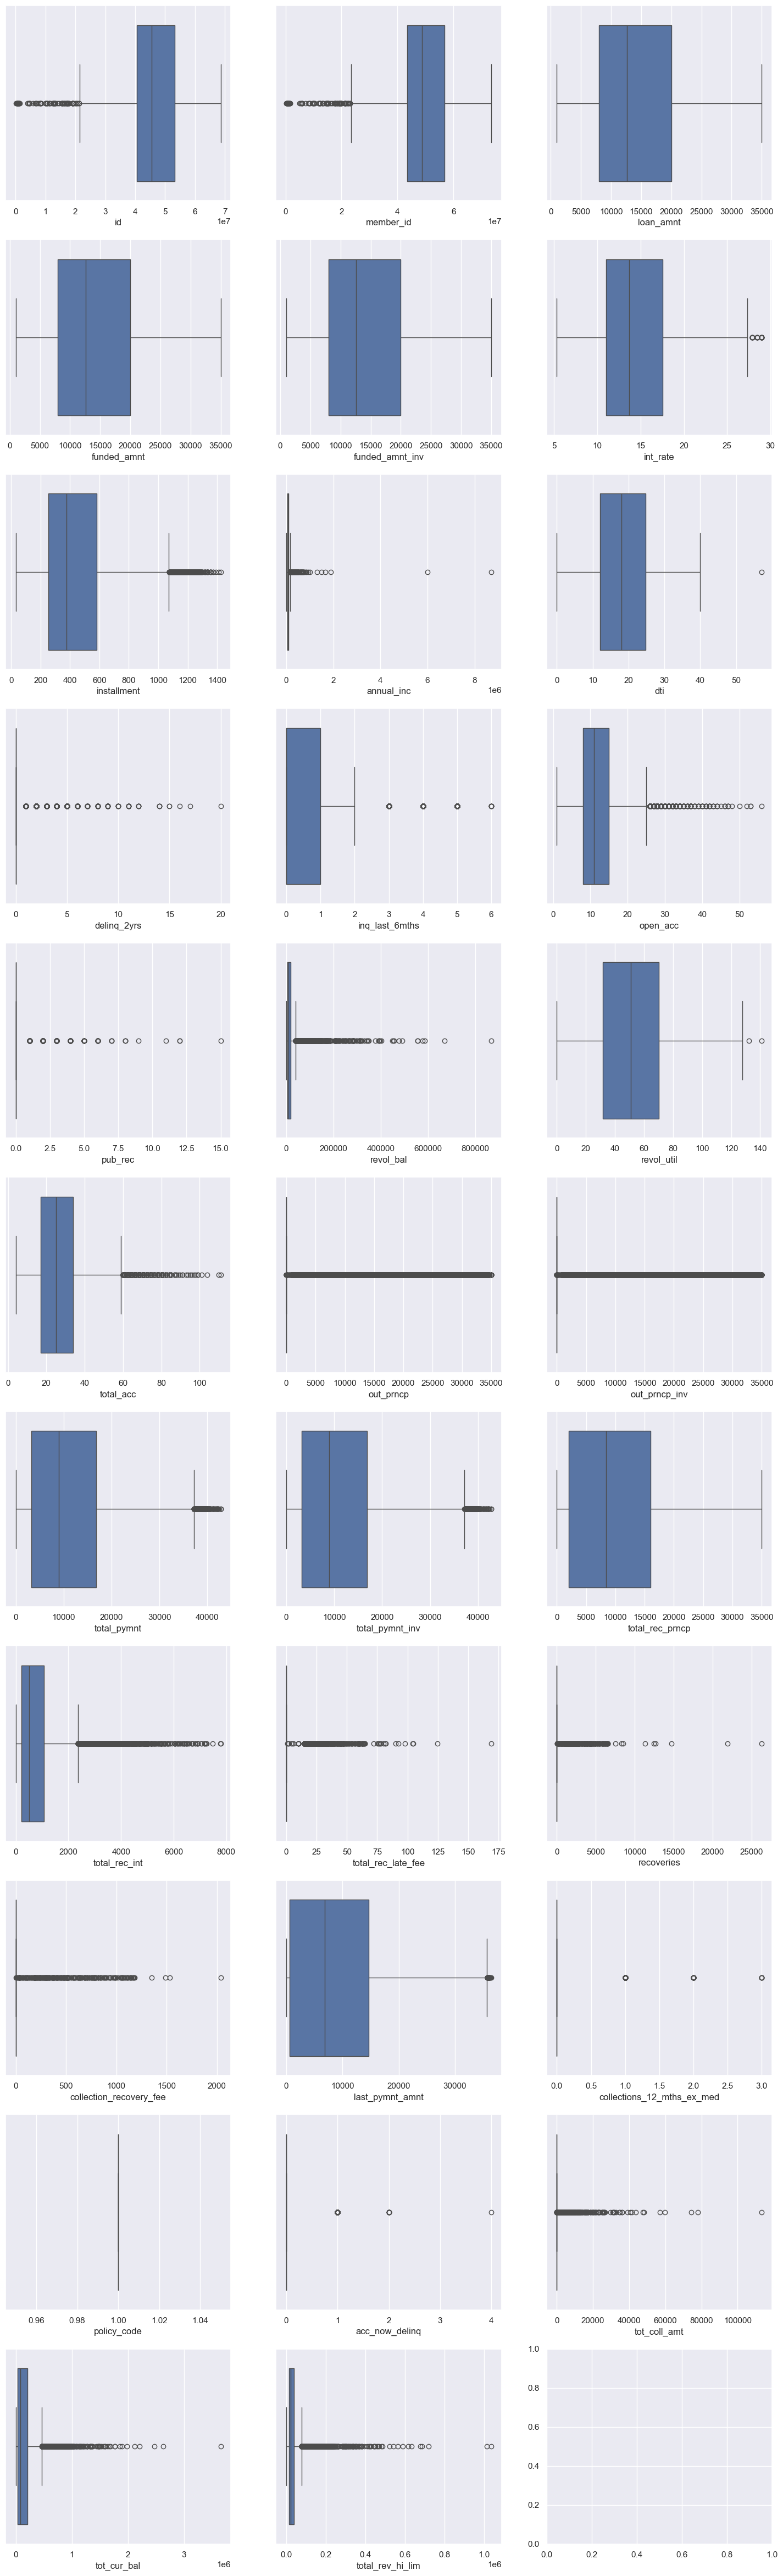

In [25]:
# Draw the distributions of all variables
f, axes = plt.subplots(11, 3, figsize=(18, 60))

count = 0
for var in num_data:
    sb.boxplot(data = num_data[var], orient = "h", ax = axes[int(count/3), int(count%3)])
    count += 1


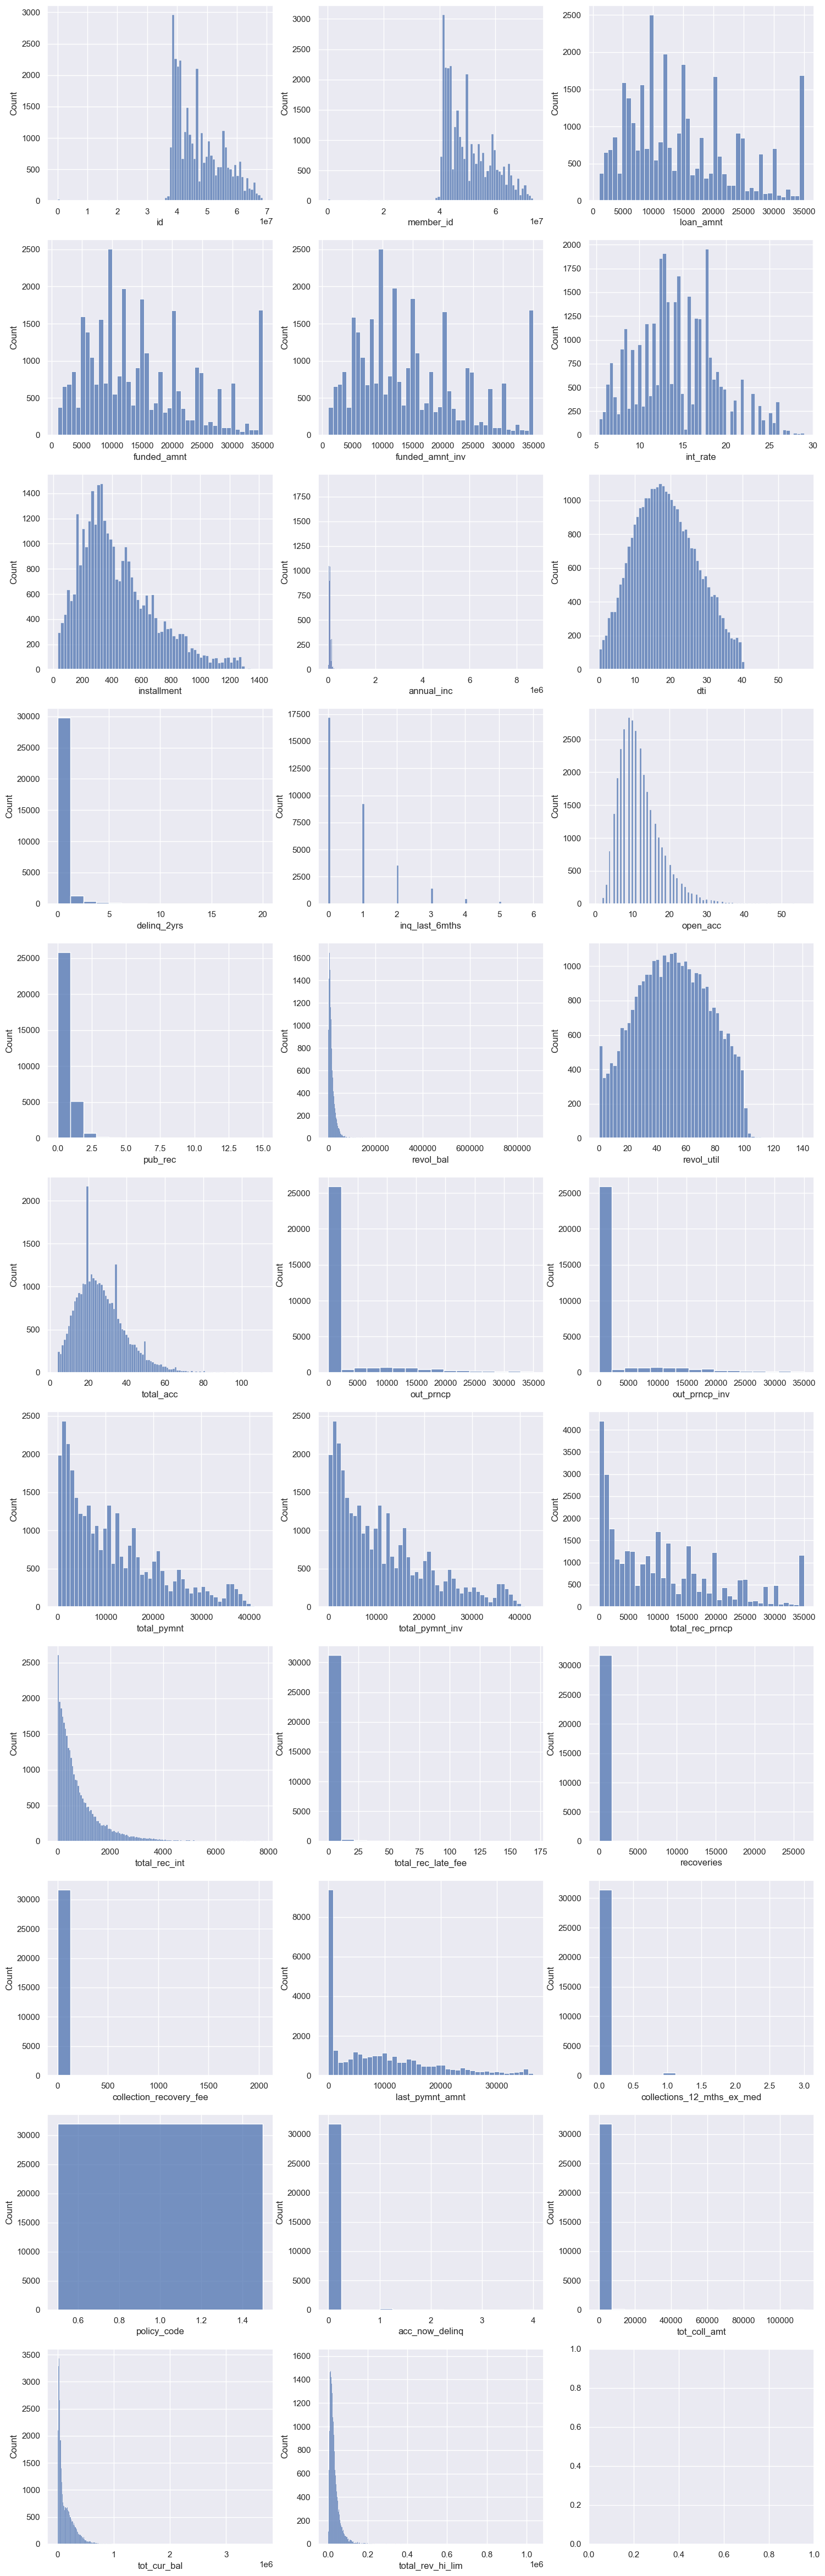

In [26]:
# Draw the distributions of all variables
f, axes = plt.subplots(11, 3, figsize=(18, 60))

count = 0
for var in num_data:
    sb.histplot(data = num_data[var], ax = axes[int(count/3), int(count%3)])
    count += 1

In [16]:
#based on chi test we chose the following to drop for chi square score under 100
loandata.drop(columns = ['title', 'application_type', 'issue_d' ,'purpose', 'earliest_cr_line', 'initial_list_status', 'addr_state'], inplace = True)

#these variables has extremely skewed distribuition and hence we chose to remove
loandata.drop(columns = ['annual_inc', 'delinq_2yrs','pub_rec','revol_bal','out_prncp','out_prncp_inv','total_rec_late_fee','recoveries','collection_recovery_fee','collections_12_mths_ex_med','policy_code','acc_now_delinq','tot_coll_amt'], inplace = True)

#identify useless variables and drop them 
loandata.drop(columns = ['id', 'member_id' , 'url','emp_title','pymnt_plan','zip_code','next_pymnt_d','grade'], inplace = True)

Chi-Square: Based on the chi-square test we did, having 100 as our minimumn threshold value, we decided to drop all variable with score lesser then 100 as that will mean that these variable do not have strong relations in affecting credit_risk and therefore does not contribute effectively to out model.

Num_Data: From the sketch of the histograms of columns in num_data, we noticed that some of these variables has extremely skewed distribuition which will cause bias in our model if its used. Hence, we remove it from our model.

We have also identified certain variables that does not aid in predicting the credit risk of individuals  
-id  
-member_id  
-url  
-emp_title  
-pymnt_plan  
-zip_code  
-next_pymnt_d  
-grade  

In [17]:
loandata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31974 entries, 0 to 421093
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   credit_risk          31974 non-null  int64  
 1   loan_amnt            31974 non-null  int64  
 2   funded_amnt          31974 non-null  int64  
 3   funded_amnt_inv      31974 non-null  int64  
 4   term                 31974 non-null  object 
 5   int_rate             31974 non-null  float64
 6   installment          31974 non-null  float64
 7   sub_grade            31974 non-null  object 
 8   emp_length           30336 non-null  object 
 9   home_ownership       31974 non-null  object 
 10  verification_status  31974 non-null  object 
 11  dti                  31974 non-null  float64
 12  inq_last_6mths       31974 non-null  int64  
 13  open_acc             31974 non-null  int64  
 14  revol_util           31955 non-null  float64
 15  total_acc            31974 non-null  int

In [18]:
for column in loandata.columns:
    if loandata[column].isna().sum() != 0:
        missing = loandata[column].isna().sum()
        portion = (missing / loandata.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'emp_length': number of missing values '1638' ==> '5.123%'
'revol_util': number of missing values '19' ==> '0.059%'
'last_pymnt_d': number of missing values '333' ==> '1.041%'
'last_credit_pull_d': number of missing values '1' ==> '0.003%'


In [9]:
#dropping the rows that has na values as it makes up a very small portion of our dataset
loandata['emp_length'] = loandata['emp_length'].fillna('0 years')

In [20]:
loandata['emp_length'] = loandata.emp_length.str.findall('([0-9]+)')
loandata['emp_length'] = loandata.emp_length.apply(lambda x: int(x[0]) if x is not np.nan else np.nan)

In [21]:
#dropping the rows that has na values as it makes up a very small portion of our dataset 
loandata.dropna(inplace=True)

In [22]:
loandata = loandata.reset_index()

In [23]:
loandata.drop(columns = ['index'], inplace = True)

In [24]:
ohe = OneHotEncoder()

cat_data = loandata.select_dtypes(include = 'object')
# OneHotEncoding of categorical predictors (not the response)
ohe.fit(cat_data)
cat_data_ohe = pd.DataFrame(ohe.transform(cat_data).toarray(), columns=ohe.get_feature_names_out(cat_data.columns))

# Check the encoded variables
cat_data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31621 entries, 0 to 31620
Data columns (total 70 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   term_ 36 months                      31621 non-null  float64
 1   term_ 60 months                      31621 non-null  float64
 2   sub_grade_A1                         31621 non-null  float64
 3   sub_grade_A2                         31621 non-null  float64
 4   sub_grade_A3                         31621 non-null  float64
 5   sub_grade_A4                         31621 non-null  float64
 6   sub_grade_A5                         31621 non-null  float64
 7   sub_grade_B1                         31621 non-null  float64
 8   sub_grade_B2                         31621 non-null  float64
 9   sub_grade_B3                         31621 non-null  float64
 10  sub_grade_B4                         31621 non-null  float64
 11  sub_grade_B5                

In [25]:
# Combining Numeric features with the OHE Categorical features
loandata_num = loandata.select_dtypes(exclude='object')
loandata_ohe = pd.concat([loandata_num, cat_data_ohe], sort = False, axis = 1).reindex(index=loandata_num.index)

# Check the final dataframe
loandata_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31621 entries, 0 to 31620
Data columns (total 89 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   credit_risk                          31621 non-null  int64  
 1   loan_amnt                            31621 non-null  int64  
 2   funded_amnt                          31621 non-null  int64  
 3   funded_amnt_inv                      31621 non-null  int64  
 4   int_rate                             31621 non-null  float64
 5   installment                          31621 non-null  float64
 6   emp_length                           31621 non-null  int64  
 7   dti                                  31621 non-null  float64
 8   inq_last_6mths                       31621 non-null  int64  
 9   open_acc                             31621 non-null  int64  
 10  revol_util                           31621 non-null  float64
 11  total_acc                   

In [26]:
pd.options.display.max_rows = 200

In [27]:
# Extract Response and Predictors
y = pd.DataFrame(loandata_ohe['credit_risk'])
X = pd.DataFrame(loandata_ohe.drop(columns = ['credit_risk']))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

# Random Forest
A Random Forest is an ensemble learning method that builds multiple decision trees during training and outputs the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random forests aim to reduce the overfitting problem of decision trees by averaging multiple trees, improving accuracy and robustness. Each tree in the ensemble is built from a random sample of the data, and at each node, a random subset of the features is considered for splitting.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6856
           1       1.00      0.99      1.00      2631

    accuracy                           1.00      9487
   macro avg       1.00      1.00      1.00      9487
weighted avg       1.00      1.00      1.00      9487


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 100.00%
False Positive Rate 		: 0.00%
False Negative Rate 		: 0.00%

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 99.83%
False Positive Rate 		: 0.00%
False Negative Rate 		: 0.61%



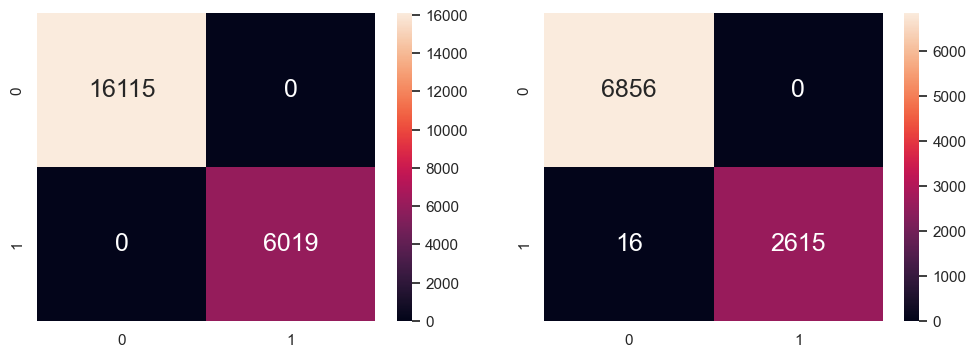

In [28]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # 100 trees

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict the labels of the test set
y_test_pred = rf_classifier.predict(X_test)
y_train_pred = rf_classifier.predict(X_train)

print("CLASSIFICATION REPORT:\n", classification_report(y_test, y_test_pred))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_train_pred).ravel()
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_test_pred).ravel()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print(f"Classification Accuracy \t: {accuracy_score(y_train, y_train_pred) * 100:.2f}%")
print(f"False Positive Rate \t\t: {fp_train/(fp_train+tn_train) * 100:.2f}%")
print(f"False Negative Rate \t\t: {fn_train/(fn_train+tp_train) * 100:.2f}%")
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print(f"Classification Accuracy \t: {accuracy_score(y_test, y_test_pred) * 100:.2f}%")
print(f"False Positive Rate \t\t: {fp_test/(fp_test+tn_test) * 100:.2f}%")
print(f"False Negative Rate \t\t: {fn_test/(fn_test+tp_test) * 100:.2f}%")
print()

# Logistic Regression

We chose Logistic Regression instead of Linear Regression as it is a statistical model that uses a logistic function to model a binary dependent variable. In the context of machine learning, it's used as a method of classification, not regression. It predicts the probability that an observed input belongs to a particular category. The outputs are transformed using a logistic (sigmoid) function to return a probability value which can then be mapped to two or more discrete classes.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6856
           1       1.00      1.00      1.00      2631

    accuracy                           1.00      9487
   macro avg       1.00      1.00      1.00      9487
weighted avg       1.00      1.00      1.00      9487


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 99.88%
False Positive Rate 		: 0.00%
False Negative Rate 		: 0.43%

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 99.87%
False Positive Rate 		: 0.00%
False Negative Rate 		: 0.46%



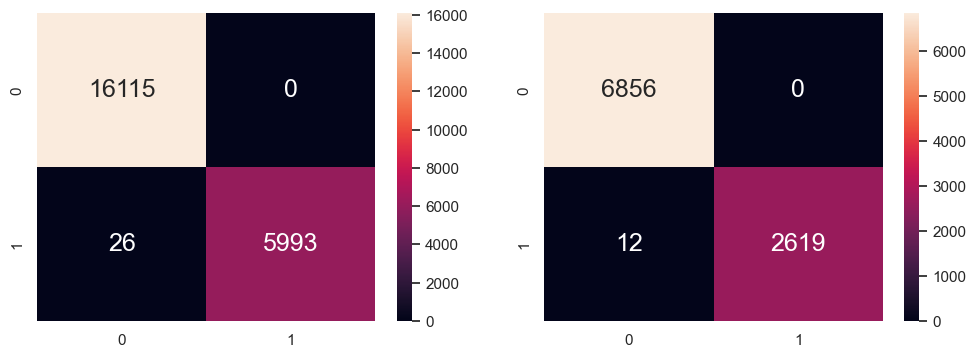

In [29]:
# Initialize the Logistic Regression model
logisticmodel = LogisticRegression()

# Fit the model on the training data
logisticmodel.fit(X_train, y_train)

# Predict the labels of the test set
y_test_pred = logisticmodel.predict(X_test)
y_train_pred = logisticmodel.predict(X_train)

print("CLASSIFICATION REPORT:\n", classification_report(y_test, y_test_pred))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_train_pred).ravel()
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_test_pred).ravel()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print(f"Classification Accuracy \t: {accuracy_score(y_train, y_train_pred) * 100:.2f}%")
print(f"False Positive Rate \t\t: {fp_train/(fp_train+tn_train) * 100:.2f}%")
print(f"False Negative Rate \t\t: {fn_train/(fn_train+tp_train) * 100:.2f}%")
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print(f"Classification Accuracy \t: {accuracy_score(y_test, y_test_pred) * 100:.2f}%")
print(f"False Positive Rate \t\t: {fp_test/(fp_test+tn_test) * 100:.2f}%")
print(f"False Negative Rate \t\t: {fn_test/(fn_test+tp_test) * 100:.2f}%")
print()

# Artificial Neural Network

Artificial Neural Networks are a subset of machine learning models inspired by the biological neural networks that constitute animal brains. An ANN is composed of layers of interconnected nodes or neurons, where each connection can transmit a signal from one node to another. ANNs are capable of learning and modeling complex relationships in data through the learning of weights on these connections, and they are particularly powerful for tasks like image recognition, natural language processing, and many other complex data-driven tasks.

In [31]:
# Build the neural network model
NNmodel = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
NNmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
NNmodel.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Evaluate the model
loss, accuracy = NNmodel.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

C:\Users\yj\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
692/692 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9286 - loss: 176.2913
Epoch 2/20
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9914 - loss: 11.0938
Epoch 3/20
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9954 - loss: 4.8288
Epoch 4/20
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9913 - loss: 10.0324
Epoch 5/20
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9949 - loss: 6.6420
Epoch 6/20
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9968 - loss: 1.7776
Epoch 7/20
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9962 - loss: 1.3419
Epoch 8/20
692/692 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9960 - loss: 2.0748
Epoch 9/20
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9934 - loss: 1.0603
Epoch 10/20
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9952 - loss: 0.5231
Epoch 11/20
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9960 - loss: 0.2091
Epoch 12/20
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
692/692 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6856
           1       1.00      0.99      1.00      2631

    accuracy                           1.00      9487
   macro avg       1.00      1.00      1.00      9487
weighted avg       1.00      1.00      1.00      9487


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 99.79%
False Positive Rate 		: 0.00%
False Negative Rate 		: 0.76%

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 99.78%
False Positive Rate 		: 0.00%
False Negative Rate 		: 0.80%



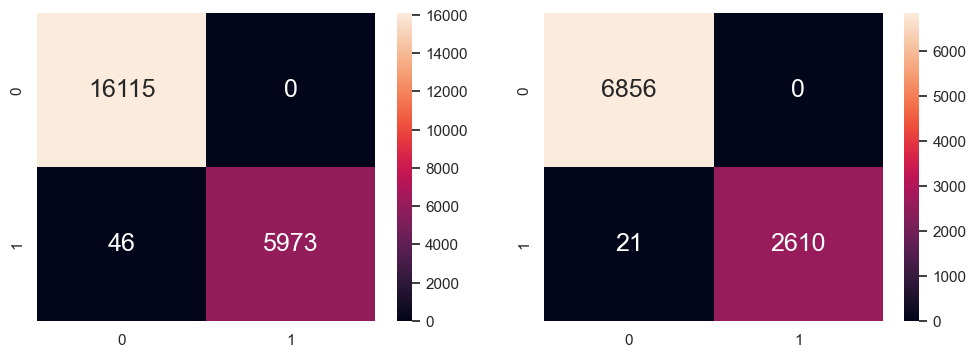

In [32]:
# Predict the labels of the test set
y_test_pred = (NNmodel.predict(X_test)).round()
y_train_pred = (NNmodel.predict(X_train)).round()

print("CLASSIFICATION REPORT:\n", classification_report(y_test, y_test_pred.round()))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_train_pred).ravel()
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_test_pred).ravel()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print(f"Classification Accuracy \t: {accuracy_score(y_train, y_train_pred) * 100:.2f}%")
print(f"False Positive Rate \t\t: {fp_train/(fp_train+tn_train) * 100:.2f}%")
print(f"False Negative Rate \t\t: {fn_train/(fn_train+tp_train) * 100:.2f}%")
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print(f"Classification Accuracy \t: {accuracy_score(y_test, y_test_pred) * 100:.2f}%")
print(f"False Positive Rate \t\t: {fp_test/(fp_test+tn_test) * 100:.2f}%")
print(f"False Negative Rate \t\t: {fn_test/(fn_test+tp_test) * 100:.2f}%")
print()

# Removing outliers from the dataset

We can observe from the 3 models above that there exists a small percentage of false negative predictions. Hence we decided to remove outliers from the data before fitting the models.

Outliers can significantly skew and mislead the training process of machine learning models resulting in less accurate models.
Outliers often represent anomalies or highly unusual instances that do not generalize across the data. Models trained on data including these outliers might perform well on similar outlier data but poorly on more typical data. Therefore, by removing outliers, the models may perform better and we will be able to make more accurate predictions.




In [35]:
def remove_outliers_IQR_iteratively(df):
    """
    Iteratively removes outliers from all numerical columns in a DataFrame based on the IQR method until no more outliers are detected.
    """
    # Flag to check if any outliers were removed
    outliers_exist = True
    while outliers_exist:
        outliers_exist = False
        cleaned_df = df.copy()
        for column_name in df.select_dtypes(include=['float64', 'int64']).columns:
            q1 = df[column_name].quantile(0.25)
            q3 = df[column_name].quantile(0.75)
            IQR = q3 - q1
            lower_bound = q1 - 1.5 * IQR
            upper_bound = q3 + 1.5 * IQR

            # Check before filtering
            if cleaned_df[(cleaned_df[column_name] < lower_bound) | (cleaned_df[column_name] > upper_bound)].any(axis=None):
                outliers_exist = True
            
            # Filter out outliers
            cleaned_df = cleaned_df[(cleaned_df[column_name] >= lower_bound) & (cleaned_df[column_name] <= upper_bound)]
        
        # Update df to the cleaned data for the next iteration
        df = cleaned_df

    return cleaned_df

# Assuming 'df' is your DataFrame containing multiple numerical columns
num_data_to_clean = loandata.copy()

cleaned_data = remove_outliers_IQR_iteratively(num_data_to_clean)
print("Number of data points after removing outliers:", len(cleaned_data))

# Plotting
#f, axes = plt.subplots(len(cleaned_data.columns) // 3 + 1, 3, figsize=(18, 60))
#for i, var in enumerate(cleaned_data.columns):
    #sb.boxplot(data=cleaned_data, x=var, orient="h", ax=axes[i // 3, i % 3])
#plt.tight_layout()
#plt.show()

Number of data points after removing outliers: 10036


In [43]:
# Import the encoder from sklearn
ohe = OneHotEncoder()

cleaned_data = cleaned_data.reset_index()
cleaned_data.drop(columns = ['index'], inplace = True)

cleaned_cat_data = cleaned_data.select_dtypes(include = 'object')
# OneHotEncoding of categorical predictors (not the response)
ohe.fit(cleaned_cat_data)
cleaned_cat_data_ohe = pd.DataFrame(ohe.transform(cleaned_cat_data).toarray(), columns=ohe.get_feature_names_out(cleaned_cat_data.columns))

# Combining Numeric features with the OHE Categorical features
cleaned_loandata_num = cleaned_data.select_dtypes(exclude='object')
cleaned_loandata_ohe = pd.concat([cleaned_loandata_num, cleaned_cat_data_ohe], sort = False, axis = 1).reindex(index=cleaned_loandata_num.index)

# Check the final dataframe
cleaned_loandata_ohe.info()

# Extract Response and Predictors
y = pd.DataFrame(cleaned_loandata_ohe['credit_risk'])
X = pd.DataFrame(cleaned_loandata_ohe.drop(columns = ['credit_risk']))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10036 entries, 0 to 10035
Data columns (total 82 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   credit_risk                          10036 non-null  int64  
 1   loan_amnt                            10036 non-null  int64  
 2   funded_amnt                          10036 non-null  int64  
 3   funded_amnt_inv                      10036 non-null  int64  
 4   int_rate                             10036 non-null  float64
 5   installment                          10036 non-null  float64
 6   emp_length                           10036 non-null  int64  
 7   dti                                  10036 non-null  float64
 8   inq_last_6mths                       10036 non-null  int64  
 9   open_acc                             10036 non-null  int64  
 10  revol_util                           10036 non-null  float64
 11  total_acc                   

# Random Forest (Model 2)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2172
           1       1.00      1.00      1.00       839

    accuracy                           1.00      3011
   macro avg       1.00      1.00      1.00      3011
weighted avg       1.00      1.00      1.00      3011


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 100.00%
False Positive Rate 		: 0.00%
False Negative Rate 		: 0.00%

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 99.83%
False Positive Rate 		: 0.09%
False Negative Rate 		: 0.36%



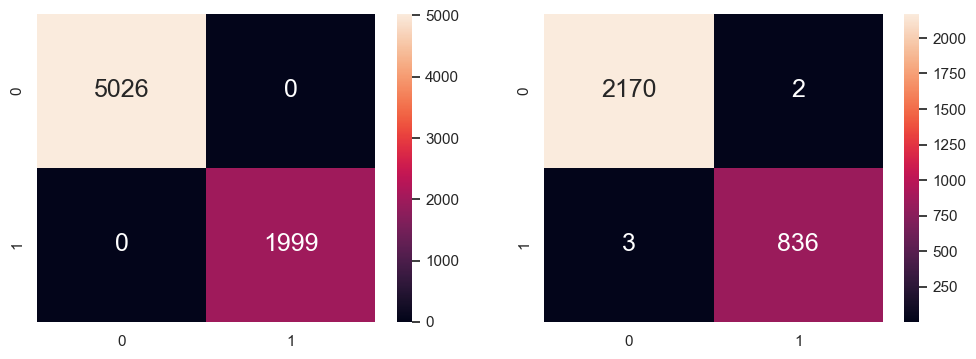

In [65]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # 100 trees

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict the labels of the test set
y_test_pred = rf_classifier.predict(X_test)
y_train_pred = rf_classifier.predict(X_train)

print("CLASSIFICATION REPORT:\n", classification_report(y_test, y_test_pred))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_train_pred).ravel()
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_test_pred).ravel()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print(f"Classification Accuracy \t: {accuracy_score(y_train, y_train_pred) * 100:.2f}%")
print(f"False Positive Rate \t\t: {fp_train/(fp_train+tn_train) * 100:.2f}%")
print(f"False Negative Rate \t\t: {fn_train/(fn_train+tp_train) * 100:.2f}%")
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print(f"Classification Accuracy \t: {accuracy_score(y_test, y_test_pred) * 100:.2f}%")
print(f"False Positive Rate \t\t: {fp_test/(fp_test+tn_test) * 100:.2f}%")
print(f"False Negative Rate \t\t: {fn_test/(fn_test+tp_test) * 100:.2f}%")
print()

# Logistic Regression (Model 2)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2172
           1       1.00      1.00      1.00       839

    accuracy                           1.00      3011
   macro avg       1.00      1.00      1.00      3011
weighted avg       1.00      1.00      1.00      3011


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 99.93%
False Positive Rate 		: 0.00%
False Negative Rate 		: 0.25%

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 99.97%
False Positive Rate 		: 0.00%
False Negative Rate 		: 0.12%



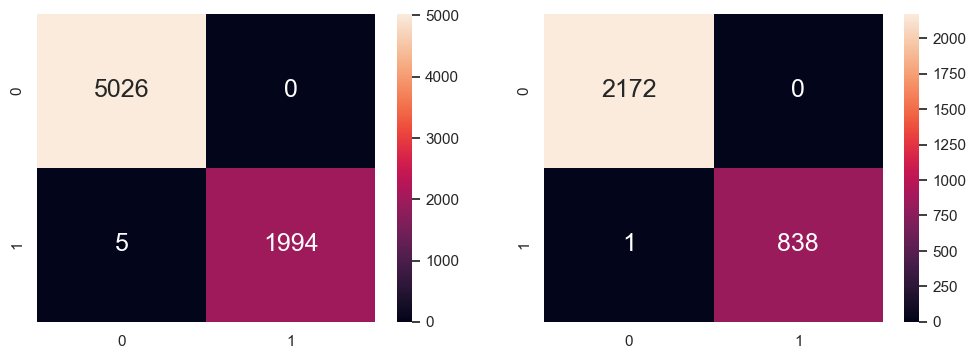

In [45]:
# Initialize the Logistic Regression model
logisticmodel = LogisticRegression()

# Fit the model on the training data
logisticmodel.fit(X_train, y_train)

# Predict the labels of the test set
y_test_pred = logisticmodel.predict(X_test)
y_train_pred = logisticmodel.predict(X_train)

print("CLASSIFICATION REPORT:\n", classification_report(y_test, y_test_pred))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_train_pred).ravel()
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_test_pred).ravel()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print(f"Classification Accuracy \t: {accuracy_score(y_train, y_train_pred) * 100:.2f}%")
print(f"False Positive Rate \t\t: {fp_train/(fp_train+tn_train) * 100:.2f}%")
print(f"False Negative Rate \t\t: {fn_train/(fn_train+tp_train) * 100:.2f}%")
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print(f"Classification Accuracy \t: {accuracy_score(y_test, y_test_pred) * 100:.2f}%")
print(f"False Positive Rate \t\t: {fp_test/(fp_test+tn_test) * 100:.2f}%")
print(f"False Negative Rate \t\t: {fn_test/(fn_test+tp_test) * 100:.2f}%")
print()

# Artificial Neural Network (Model 2)

In [49]:
# Build the neural network model
NNmodel = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
NNmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
NNmodel.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Evaluate the model
loss, accuracy = NNmodel.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Epoch 1/20


C:\Users\yj\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9333 - loss: 50.3272
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9889 - loss: 1.9183
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9898 - loss: 2.5300
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9921 - loss: 1.7387
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9955 - loss: 1.2459
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9960 - loss: 0.9436
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9976 - loss: 0.4660
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9949 - loss: 1.2767
Epoch 9/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9974 - loss: 0.6808
Epoch 10/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9962 - loss: 1.0988
Epoch 11/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9966 - loss: 0.8561
Epoch 12/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accurac

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      2172
           1       0.97      1.00      0.99       839

    accuracy                           0.99      3011
   macro avg       0.99      0.99      0.99      3011
weighted avg       0.99      0.99      0.99      3011


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 99.43%
False Positive Rate 		: 0.70%
False Negative Rate 		: 0.25%

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 99.24%
False Positive Rate 		: 1.01%
False Negative Rate 		: 0.12%



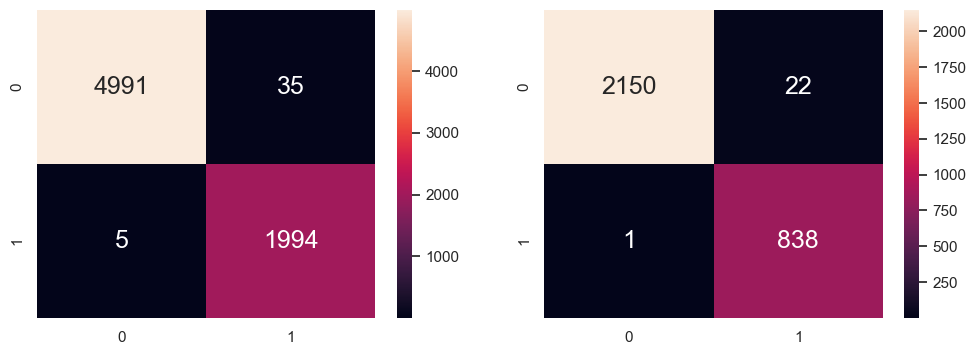

In [50]:
# Predict the labels of the test set
y_test_pred = (NNmodel.predict(X_test)).round()
y_train_pred = (NNmodel.predict(X_train)).round()

print("CLASSIFICATION REPORT:\n", classification_report(y_test, y_test_pred.round()))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_train_pred).ravel()
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_test_pred).ravel()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print(f"Classification Accuracy \t: {accuracy_score(y_train, y_train_pred) * 100:.2f}%")
print(f"False Positive Rate \t\t: {fp_train/(fp_train+tn_train) * 100:.2f}%")
print(f"False Negative Rate \t\t: {fn_train/(fn_train+tp_train) * 100:.2f}%")
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print(f"Classification Accuracy \t: {accuracy_score(y_test, y_test_pred) * 100:.2f}%")
print(f"False Positive Rate \t\t: {fp_test/(fp_test+tn_test) * 100:.2f}%")
print(f"False Negative Rate \t\t: {fn_test/(fn_test+tp_test) * 100:.2f}%")
print()

# Comparing the models

After removing the outliers, we can observe a slight decrease in the False Negative Rate for all 3 models. However, we also observe that the is an increase in the False Positive Rate for Random Forest and Artificial Neural Network. Based on the various metrics for the 3 models, we have concluded that the Logistic Regression model is the most suitable model as it produces a lower False Positive and Negative rates on the test dataset.

# Categorising loan applicants

In [84]:
# Predict probabilities of Risky or Non-Risky
y_scores = logisticmodel.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold is:", optimal_threshold)

Optimal threshold is: 0.7923427123897929


In [85]:
def risk_category(prob):
    # Based on the optimal threshold
    if prob < (1-0.7923427123897929):
        return 'Low Risk'
    else:
        return 'High Risk'

risk_levels = {'Low Risk': 0, 'High Risk': 0}

for p in y_scores:
    risk_levels[risk_category(p)] += 1

print(risk_levels)

{'Low Risk': 2171, 'High Risk': 840}


# Determining optimal threshold 

Depending on the banks decision, we should consider changing the threshold value of the probability if the model is showing high rates of false positives or false negatives. For example, if the model is classifying many False Positives, it may cause a high number of unapproved loans for creditworthy applicants. In this case, the bank might want to change the decision boundary to be more lenient, resulting in fewer false positives and more loans being approved. 

On the other hand, if the model is classifying many False Negatives, it may be cause a high level of loan defaults and financial loss for the lender. In this case, the lender might want to change the decision boundary to be more strict, resulting in fewer false negatives and more defaults being identified. 

Therefore, it is important to consider the business and regulatory context in which the model will be used when deciding on the threshold value.

# Conclusion

Credit risk modeling is designed to enhance a bank's capability to forecast potential loan defaults among its customers. By examining past instances of default and predicting future risks, the bank can implement measures to mitigate its overall risk and boost its profitability. Employing statistical methods and machine learning algorithms enables the analysis of extensive loan data, helping to pinpoint patterns and trends that suggest an increased risk of default.